In [1]:
# including the project directory to the notebook level
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
from tqdm import tqdm
import parse
import warnings

In [2]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    import tensorflow as tf
    config = tf.ConfigProto(log_device_placement=False)
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    
    from keras import backend as K
    from nn_source import models as mp
from dataprocess import dataprocessor as dp
from dataprocess import plotutils as pu

Using TensorFlow backend.


In [3]:
# read the pickled file for ahu data
ahudata = dp.readfile('../data/processed/ahu1energy.pkl')

# return pickled df
ahu = ahudata.return_df(processmethods=['file2df'])

# read the pickled file for ghi data
ghidata = dp.readfile('../data/processed/ghi.pkl')

# return pickled df
ghi = ghidata.return_df(processmethods=['file2df'])

In [4]:
# selecting only required columns and rearranging them
ahu = ahu[[
    'AHU_1 outdoorAirTemp', 'WeatherDataProfile humidity',
    'AHU_1 supplyAirTemp', 'HW_BTU_METER currentKbtuDeltaReading',
    'CHW_BTU_METER currentKbtuDeltaReading'
]]

# renaming columns
ahu.columns = ['oat', 'orh', 'sat', 'hwe', 'cwe']

# Total energy is sum of heating and coling
ahu['totale'] = ahu['hwe'] + ahu['cwe']
# dropping heating and cooling energy columns
ahu = ahu.drop(columns=['hwe', 'cwe'])

In [5]:
# merging ahu and ghi data
df = dp.merge_df_columns([ahu, ghi])

# rearranging columns
df = df[['oat', 'orh', 'sat', 'Ghi', 'totale']]

In [6]:
df.head()

,oat,orh,sat,Ghi,totale
2018-07-12 13:55:00,89.554909,76.0,75.443275,872.0,35.590466
2018-07-12 14:00:00,89.863190,76.0,75.443275,866.0,33.027813
2018-07-12 14:05:00,89.863190,76.0,75.443275,859.0,31.769627
2018-07-12 14:10:00,90.484146,69.0,75.443275,848.0,34.195641
2018-07-12 14:15:00,90.826981,69.0,75.443275,836.0,31.082222


In [ ]:
df['HourSine'] = np.sin(2 * np.pi * df.index.hour / 24.0)
df['HourCos'] = np.cos(2 * np.pi * df.index.hour / 24.0)
df['WeekSine'] = np.sin(2 * np.pi * df.index.week / 52.0)
df['WeekCos'] = np.cos(2 * np.pi * df.index.week / 52.0)
df['DayofWeekSine'] = np.sin(2 * np.pi * df.index.dayofweek / 7.0)
df['DayofWeekCos'] = np.cos(2 * np.pi * df.index.dayofweek / 7.0)

In [ ]:
df = df[[
    'oat', 'orh', 'sat', 'Ghi', 'HourSine', 'HourCos', 'WeekSine', 'WeekCos',
    'DayofWeekSine', 'DayofWeekCos', 'totale'
]]

In [ ]:
df.head()

In [7]:
# Creating a list of 7 day dataframes for training
dflist = dp.df2dflist(df, subsequence=True, period=1, days=7, hours=0)

In [8]:
len(dflist)

22

In [16]:
dflist = [df]

In [17]:
# create list of training, testing arrays
weeklist = []
for weekdata in dflist:
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        weekdata,
        predictorcols=['oat', 'orh', 'sat', 'Ghi'],
        outputcols=['totale'],
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=-1
    )
    weeklist.append({
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })

In [18]:
for i in weeklist[0].keys():
    print(weeklist[0][i].shape)

(122274, 1, 4)
(122274, 1, 1)
(40758, 1, 4)
(40758, 1, 1)


In [23]:
!rm -rf ../results/lstmtrain3

In [24]:
# create the results directory
try:
    os.mkdir('../results/lstmtrain3/')
except FileExistsError:
    files = os.listdir('../results/lstmtrain3/')
    for f in files:
        os.remove('../results/lstmtrain3/' + f)
        
os.mkdir('../results/lstmtrain3/loginfo')

In [25]:
try:
    del model
except NameError:
    pass

K.clear_session()

In [26]:
config = {
    'weeklist': weeklist,
    'lstm_hidden_units': 8,
    'lstm_no_layers': 1,
    'dense_hidden_units': 32,
    'dense_no_layers': 4
}

modeldesigndone = False
initial_epoch = 0
for weekno, weekdata in enumerate(tqdm(config['weeklist'])):

    X_train = weekdata['X_train']
    y_train = weekdata['y_train']
    X_test = weekdata['X_test']
    y_test = weekdata['y_test']

    if not modeldesigndone:
        #Instantiate learner model
        model = mp.lstm_model('../results/lstmtrain3/',
                              inputdim=X_train.shape[-1],
                              outputdim=y_train.shape[-1],
                              period=1)

        # Desing model architecture
        model.design_model(lstmhiddenlayers=[config['lstm_hidden_units']] * config['lstm_no_layers'],
                           densehiddenlayers=[config['dense_hidden_units']] * config['dense_no_layers'],
                           dropoutlist=[[], []],
                           batchnormalizelist=[[], []])

        # creating early stopping and learning reate changing callbacks
        model.model_callbacks()

        modeldesigndone = True

    # train the model
    history = model.train_model(X_train, y_train, X_test, y_test, epochs=500, initial_epoch = initial_epoch)
    initial_epoch += len(history.history['loss'])

    # evaluate the model for metrics at this stage
    # see inside results folder to look at t
    # train and test plots as well as logged errors inside the text file
    preds_train, preds_test = model.evaluate_model(X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   y_scaler,
                                                   scaling=True,
                                                   saveplot=True,
                                                   Week=weekno)


  0%|          | 0/1 [00:00<?, ?it/s]findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
/data/nauga/SmartBuildings/AlumniHallResearch/AdaptiveController/cdc20/dataprocess/plotutils.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(saveloc+str(timegap)+'_LSTM_'+typeofplot+'prediction-Week{}.pdf'.format(Week), bbox_inches='tight')
/data/nauga/SmartBuildings/AlumniHallResearch/AdaptiveController/cdc20/dataprocess/plotutils.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(saveloc+str(timegap)+'_LSTM_'+typeofplot+'prediction-Week{}.pdf'.format(Week), bbox_inches='tight')

100%|██████████| 1/1 [49:42<00:00, 2982.67s/it]


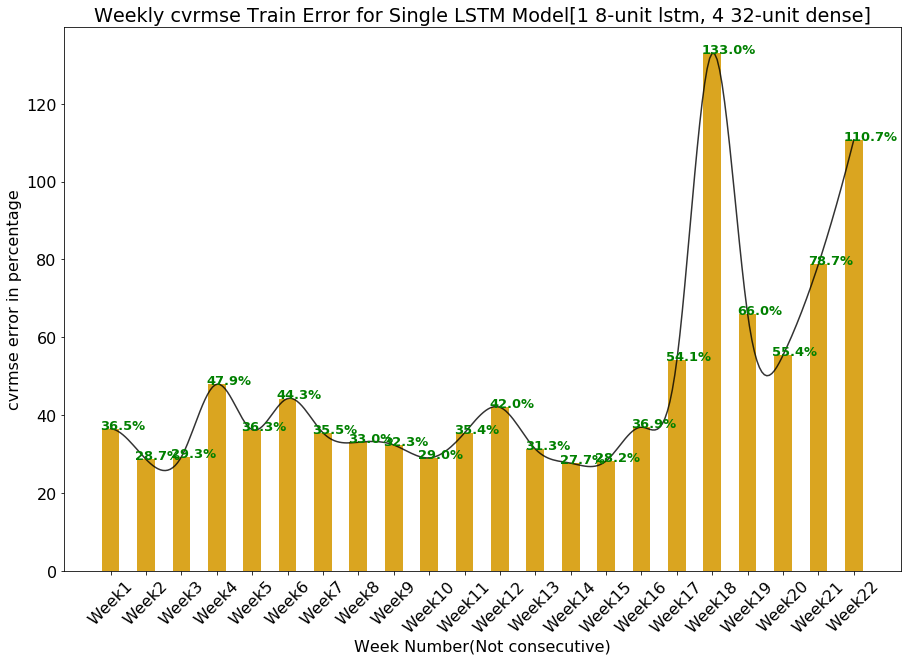

In [7]:
# Open a file
fo = open("../results/lstmtrain/5min Results_File.txt", "r")
print ("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Week No:{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train':{'rmse': [], 'cvrmse' : [], 'mae' : []},
    'Test':{'rmse': [], 'cvrmse' : [], 'mae' : []}
}
for line in lines:
    p = parse.parse(parse_format,line)
    stats[p[2]]['rmse'].append(float(p[3]))
    stats[p[4]]['cvrmse'].append(float(p[5]))
    stats[p[6]]['mae'].append(float(p[7]))
          
fo.close()

# from dataprocess import plotutils as pu
plot_args = dict(
    bars = stats['Train']['cvrmse'],
    color = 'goldenrod',
    bar_label = 'cvrmse',
    saveloc = '../results/lstmtrain',
    smoothcurve = True,
    bar_annotate = True,
    saveplot = True,
    xlabel = 'Week Number(Not consecutive)',
    ylabel = 'cvrmse error in percentage',
    title = 'Weekly cvrmse Train Error for Single LSTM Model[1 8-unit lstm, 4 32-unit dense]',
    xticktype = 'Week'
)
pu.single_bar_plot(
    **plot_args
)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


Name of the file:  ../results/lstmtrain2/5min Results_File.txt


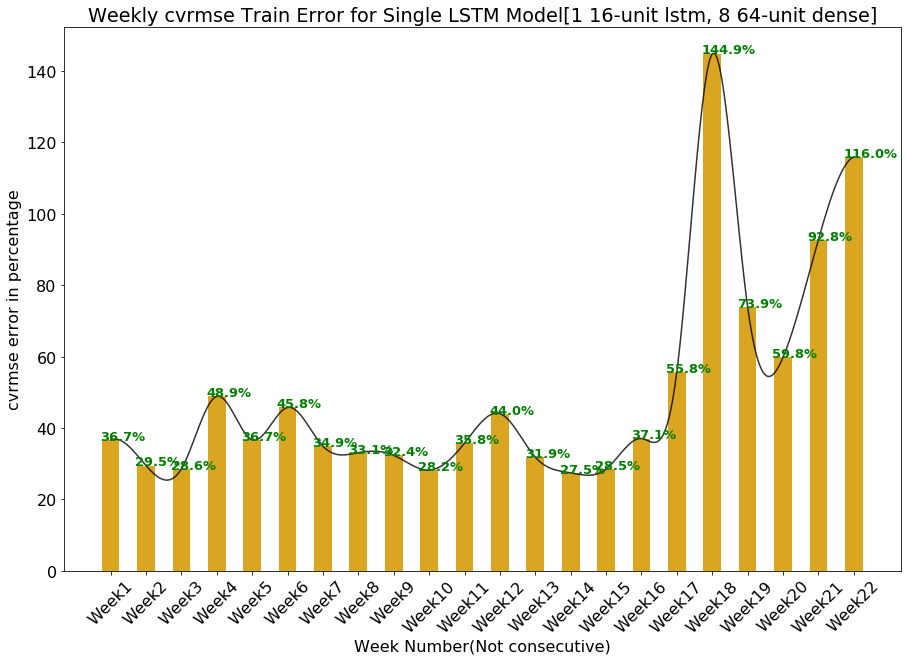

In [15]:
# Open a file
fo = open("../results/lstmtrain2/5min Results_File.txt", "r")
print ("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Week No:{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train':{'rmse': [], 'cvrmse' : [], 'mae' : []},
    'Test':{'rmse': [], 'cvrmse' : [], 'mae' : []}
}
for line in lines:
    p = parse.parse(parse_format,line)
    stats[p[2]]['rmse'].append(float(p[3]))
    stats[p[4]]['cvrmse'].append(float(p[5]))
    stats[p[6]]['mae'].append(float(p[7]))
          
fo.close()

# from dataprocess import plotutils as pu
plot_args = dict(
    bars = stats['Train']['cvrmse'],
    color = 'goldenrod',
    bar_label = 'cvrmse',
    saveloc = '../results/lstmtrain',
    smoothcurve = True,
    bar_annotate = True,
    saveplot = True,
    xlabel = 'Week Number(Not consecutive)',
    ylabel = 'cvrmse error in percentage',
    title = 'Weekly cvrmse Train Error for Single LSTM Model[1 16-unit lstm, 8 64-unit dense]',
    xticktype = 'Week'
)
pu.single_bar_plot(
    **plot_args
)

In [ ]:
# Open a file
fo = open("../results/lstmtrain3/5min Results_File.txt", "r")
print ("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Week No:{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train':{'rmse': [], 'cvrmse' : [], 'mae' : []},
    'Test':{'rmse': [], 'cvrmse' : [], 'mae' : []}
}
for line in lines:
    p = parse.parse(parse_format,line)
    stats[p[2]]['rmse'].append(float(p[3]))
    stats[p[4]]['cvrmse'].append(float(p[5]))
    stats[p[6]]['mae'].append(float(p[7]))
          
fo.close()

# from dataprocess import plotutils as pu
plot_args = dict(
    bars = stats['Train']['cvrmse'],
    color = 'goldenrod',
    bar_label = 'cvrmse',
    saveloc = '../results/lstmtrain2',
    smoothcurve = True,
    bar_annotate = True,
    saveplot = True,
    xlabel = 'Single Data Frame',
    ylabel = 'cvrmse error in percentage',
    title = 'Cvrmse Train Error for Single LSTM Model[1 8-unit lstm, 4 32-unit dense]',
    xticktype = 'Week',
)
pu.single_bar_plot(
    **plot_args
)

In [ ]:
model.show_model()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir '../results/lstmtrain/loginfo/' --port 8200

In [ ]:
dp.dataframeplot(dflist[2], lazy=False, style='-', legend=True)